In [1]:
import torch
import torch.nn as nn
import nltk
from PIL import Image
from torch.autograd import Variable
from utils.build_vocab import Vocabulary
from model import  EncoderCNN, DecoderRNN
from utils.data_loader import get_loader
from collections import Counter
import pickle
from sys import path
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
import numpy as np
from numpy.random import random_sample
%matplotlib inline

In [2]:
with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
encoder = EncoderCNN(256)
encoder.eval()
decoder = DecoderRNN(256, 512, len(vocab), 1)
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
encoder.load_state_dict(torch.load('models/encoder_pretrained.pkl'))
decoder.load_state_dict(torch.load('models/decoder_pretrained.pkl'))
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])
rt_image = 'data/val_resized2014'
annotations = 'data/annotations/captions_val2014.json'
data_loader = get_loader(rt_image, annotations, vocab, transform, 1, False, 1)
assert len(vocab) == decoder.linear.out_features


/home/AD/irehg/anaconda2/envs/update-pytorch/lib/python2.7/site-packages/torch/backends/cudnn/__init__.py:48: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "


data/annotations/captions_val2014.json
loading annotations into memory...
0:00:00.592481
creating index...
index created!


In [3]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [4]:
for i, (image, caption, length, img_id, ann_id) in enumerate(data_loader):
    break
image_tensor = to_var(image, volatile=True)
caption = to_var(caption) # (1, 20(caption length))
image = np.transpose(image[0].numpy(), (1,2,0))
feature = encoder(image_tensor)

In [5]:
def decode_caption(caption):
    return ' '.join([vocab.idx2word[word_id] for word_id in caption.data.squeeze(0)])
print(decode_caption(caption))

<start> several planes lined up on a runway during a cloudy day . <end>


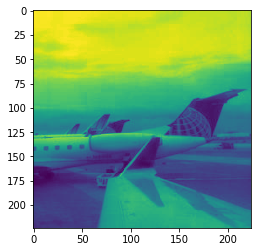

In [6]:
plt.imshow(image[:,:,0])

Naive training method. Latent state appears to converge to a local minimum of ce loss for the given sample.

Training with word dropout

In [7]:
# randomly select a set of indices from a range of given size
def rand_select(size, drop_likelihood=0.5):
    probs = random_sample(size)
    return np.where(probs > drop_likelihood)[0]

Now normalizing gradient update

In [13]:
norm_update = False
dropout = 0.9
z_param = nn.Parameter(feature.data.clone())
z_param.data.uniform_()
num_itr = 1000
print_rate = 100 # number of itrs to wait before printing
num_gt = 5
lr = 

embed = decoder.embed(caption) # (1, 20(caption length), 256)
criterion = nn.CrossEntropyLoss()

print('gt caption: {}\n'.format(decode_caption(caption)))

for j in range(num_itr):
    # sample predicted captions
    hiddens = []
    _, states = decoder.lstm(z_param.unsqueeze(1))
    for i in range(num_gt):
        h, states = decoder.lstm(embed[:,i:i+1], states)
        hiddens.append(h)
    hiddens = torch.cat(hiddens, 1) # (1, num_gt, 512)
    output = decoder.linear(hiddens[0]).unsqueeze(0) # (1, num_gt, len(vocab))

    predicted = output.max(2)[1] # (1, num_gt)
    if j % print_rate == 0:
        print(decode_caption(predicted))
    
    if len(np.where(predicted.data == caption[:,0:num_gt].data)) == num_gt:
        print(decode_caption(predicted))
        break
        
    # apply random dropout
    selected = rand_select(num_gt, dropout)
    if len(selected) == 0:
        continue
    
    # treating time dimension as batch dimension
    loss = criterion(output[0][selected], caption[0][selected])
    loss.backward(retain_graph=True)
    
    # update z_param
    update = z_param.grad.data
    norm = np.linalg.norm(update)

    if norm == 0.0:
        break
    if norm_update:
        update /= float(norm)
    z_param.data -= update * lr
    z_param.grad.data.zero_()

gt caption: <start> several planes lined up on a runway during a cloudy day . <end>

a people on up in


Try training from noise